Implement the three baselines from CLAIRE and evaluate them on the validation set of the Adult dataset as in FADE.

In [1]:
%reload_ext autoreload
%autoreload 2
import os
import sys
sys.path.append("..")
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [4]:
train_data_obs = pd.read_csv('../data/adult/train_betahats.csv')  # observed data
train_data_cf = pd.read_csv('../data/adult/train_betahats_cf_claire.csv')  # counterfactual data
train_data = pd.concat([train_data_obs, train_data_cf], axis=0)  # full augmented data

val_data = pd.read_csv('../data/adult/validate.csv')

train_data.shape, val_data.shape

((29304, 5), (9769, 5))

In [5]:
train_data.head()

,age,education_num,sex,income,loan_approved
0,82,9,0,0,1
1,53,9,0,0,0
2,24,13,0,0,1
3,37,10,1,0,1
4,68,9,1,0,0


In [6]:
val_data.head()

,age,education_num,sex,income,loan_approved
0,58,9,0,0,0
1,40,14,0,1,1
2,24,9,0,0,1
3,35,9,0,0,1
4,65,10,0,0,1


In [7]:
covariates = ['age', 'education_num']
protected = 'sex'
all_covariates = covariates + [protected]
outcome = 'income'
decision = 'loan_approved'

Following the procedure in FADE for the counterfactual setting:
> We only train on data in which D = 0: under the ignorability assumption, E[Y|A,X,D=0] = E[Y(0)|A,X], so this results in predictors which are designed to estimate Y(0).

In [8]:
train_data = train_data.loc[train_data[decision].eq(0)]
len(train_data)

9990

In [9]:
from sklearn.metrics import mean_squared_error, roc_auc_score
from src.metrics import independence_violation, deltahatplus, deltahatminus, counterfactual_fairness_mmd


def predict(model, data, continuous=True):
    """Generate predictions from trained model."""
    if continuous and hasattr(model, 'predict_proba'):
        Z = model.predict_proba(data)[:, 1]
    else:
        Z = model.predict(data)

    Z = np.clip(Z, 0, 1)
    return Z


def evaluate(model, data, covariates, protected, outcome):
    preds = predict(model, data[covariates])

    # Risk
    mse = mean_squared_error(data[outcome], preds)
    auc = roc_auc_score(data[outcome], preds)

    # Fairness 
    rate_diff = independence_violation(data[protected], preds)
    fpr_diff = deltahatplus(data[protected], data[outcome], preds)
    fnr_diff = deltahatminus(data[protected], data[outcome], preds)
    mmd = counterfactual_fairness_mmd(model, data[covariates].values, [0, 1])
    
    return {
        'MSE': mse, 'AUC': auc,
        'rate-diff': rate_diff, 'FPR-diff': fpr_diff, 'FNR-diff': fnr_diff, 'MMD': mmd
    }

In [10]:
metrics_val = []

**CLAIRE Baselines**:

**Constant Predictor**: A predictor which has constant output for any input. We obtain this constant predictor by finding a constant which can minimize the mean squared error (MSE) loss on the training data.

In [11]:
from sklearn.dummy import DummyRegressor

model_constant = DummyRegressor(strategy='mean')
model_constant.fit(train_data[covariates], train_data[outcome])

results_constant = evaluate(model_constant, val_data, covariates, protected, outcome)
metrics_val.append({'model': 'Constant', **results_constant})

**Full Predictor**:  Full predictor takes all the observed attributes (except the attribute used as label) as input for prediction.

In [12]:
from sklearn.ensemble import RandomForestClassifier

model_full = RandomForestClassifier(random_state=42)
model_full.fit(train_data[all_covariates], train_data[outcome])

results_full = evaluate(model_full, val_data, all_covariates, protected, outcome)
metrics_val.append({'model': 'Full', **results_full})

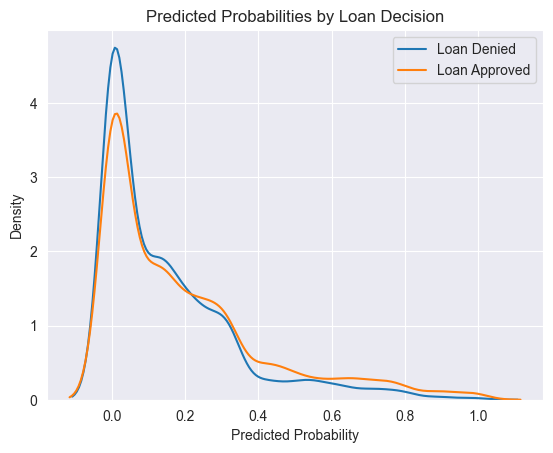

In [13]:
preds_full = predict(model_full, val_data[all_covariates])
val_full = val_data.copy().assign(preds_full=preds_full)

sns.kdeplot(val_full.loc[val_full[decision].eq(0), 'preds_full'], label='Loan Denied')
sns.kdeplot(val_full.loc[val_full[decision].eq(1), 'preds_full'], label='Loan Approved')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.title('Predicted Probabilities by Loan Decision')
plt.legend()
plt.show()

**Unaware Predictor**: Unaware predictor is based on the notion of *fairness through unawareness*. It takes all features except the sensitive attribute as input to predict the label.

In [14]:
from sklearn.ensemble import RandomForestClassifier

model_unaware = RandomForestClassifier(random_state=42)
model_unaware.fit(train_data[covariates], train_data[outcome])

results_unaware = evaluate(model_unaware, val_data, covariates, protected, outcome)
metrics_val.append({'model': 'Unaware', **results_unaware})

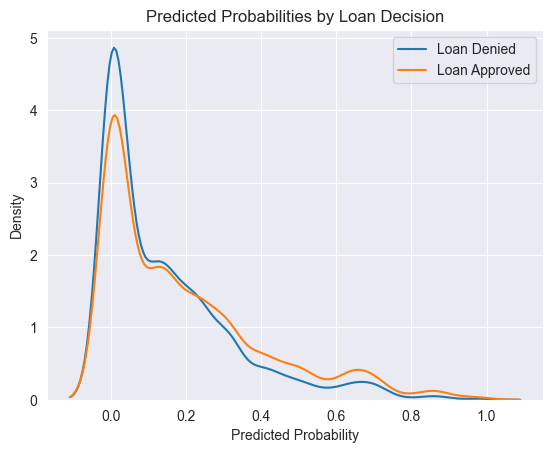

In [15]:
preds_unaware = predict(model_unaware, val_data[covariates])
val_unaware = val_data.copy().assign(preds_unaware=preds_unaware)

sns.kdeplot(val_unaware.loc[val_unaware[decision].eq(0), 'preds_unaware'], label='Loan Denied')
sns.kdeplot(val_unaware.loc[val_unaware[decision].eq(1), 'preds_unaware'], label='Loan Approved')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.title('Predicted Probabilities by Loan Decision')
plt.legend()
plt.show()

Final baseline metrics on validation set:

In [16]:
metrics = pd.DataFrame(metrics_val).set_index('model')
metrics.index.name = None
metrics.round(2)

,MSE,AUC,rate-diff,FPR-diff,FNR-diff,MMD
Constant,0.20,0.50,0.00,0.00,0.00,0.0
Full,0.17,0.73,0.03,0.01,0.01,0.0
Unaware,0.17,0.74,0.03,0.01,0.02,0.0


In [17]:
with open('../models/adult/baselines_aug.tex', 'w') as f:
    f.write(metrics.to_latex(float_format='%0.2f', bold_rows=False))

In [18]:
# Scientific notation
metrics["MMD"].apply(lambda x: '%.1e' % x)

Constant    0.0e+00
Full        1.3e-03
Unaware     0.0e+00
Name: MMD, dtype: object